In [1]:
import scipy.io
from nn_descent import run_descent

T = scipy.io.loadmat('data/T.mat')['T']
C = scipy.io.loadmat('data/C.mat')['C']
O_mat = scipy.io.loadmat('data/O_mat.mat')['O_mat']
S_tensor = scipy.io.loadmat('data/S_tensor.mat')['S_tensor']
ans = run_descent(O_mat, T, S_tensor, C, C.shape[1])


tensor(0.0020, grad_fn=<MseLossBackward>)
tensor(0.0020, grad_fn=<MseLossBackward>)


/home/sagar/matlab/venv/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


tensor(0.0020, grad_fn=<MseLossBackward>)
tensor(0.0020, grad_fn=<MseLossBackward>)
tensor(0.0020, grad_fn=<MseLossBackward>)
tensor(0.0020, grad_fn=<MseLossBackward>)
tensor(0.0020, grad_fn=<MseLossBackward>)
tensor(0.0020, grad_fn=<MseLossBackward>)
tensor(0.0020, grad_fn=<MseLossBackward>)
tensor(0.0020, grad_fn=<MseLossBackward>)


In [44]:
from networks.adversarial_model import EncoderDecoder
from networks.vae import Decoder
import torch
import numpy as np
import scipy.io
import torch.nn as nn
import matplotlib.pyplot as plt

dec = Decoder()
lr = 0.01
loop_count = 1

slf_network = EncoderDecoder()
PATH1 = '/home/sagar/Projects/deep_completion/deep_slf/trained-models/l1_5_unnorm_raw_rand_samp.model'
checkpoint = torch.load(PATH1, map_location=torch.device('cpu'))
slf_network.load_state_dict(checkpoint['model_state_dict'])

criterion = nn.MSELoss()

def outer(mat, vec):
    prod = torch.zeros(( *vec.shape,*mat.shape), dtype=torch.float32)
    for i in range(len(vec)):
        prod[i,:,:] = mat*vec[i]
    return prod

def get_tensor(S, C):
    prod = 0
    for i in range(C.shape[0]):
        prod += outer(S[i,:,:], C[i,:])
    return prod

def run_descent(W, X, z, C, R):
    """
    Arguments:
        W : Mask 
        X : sampled tensor
        z : current latent vectors estimate for R emitters
        C : current psd estimate

    Returns:
        the updated latent vector estimate
    """
    # Prepare data
    W = torch.from_numpy(W).type(torch.float32)
    X = torch.from_numpy(X).type(torch.float32)
    z = torch.from_numpy(z).type(torch.float32)
    C = torch.from_numpy(C).type(torch.float32)
    R = int(R)

    K = X.shape[2]

    X = X.permute(2,0,1)
    z = z.permute(2,0,1)
    z = z.unsqueeze(dim=1)
    C = C.permute(1,0)
    W = W.unsqueeze(dim=0)
    W = W.unsqueeze(dim=0)
    Wr = W.repeat(R,1,1,1)
    Wx = W.repeat(K,1,1,1)

    test_slf = torch.cat((Wr, z), dim=1)
    test_slf.requires_grad = True
    
    for i in range(loop_count):
        slf_complete = slf_network(test_slf)
        
#         plt.imshow(slf_complet)
        # slf_complete = slf_complete.view(R,51,51)
        # reconstruct the map from slf 
        # first normalize slf
        # slf_complete_norm = torch.zeros((slf_complete.shape))
        # for rr in range(R):
        #     slf_complete[rr] = slf_complete[rr]/(slf_complete[rr].norm())
        X_from_slf = get_tensor(slf_complete[:,0,:,:], C)
        
        loss = criterion(Wx*X, Wx*X_from_slf)
        print(loss)
        loss.backward()
        with torch.no_grad():
            test_slf -= lr*test_slf.grad
    slf_opt = test_slf[:,1,:,:]
#     return slf_opt.permute(1,2,0)
    return slf_complete

def model(z):
    input_mat = torch.from_numpy(z)
    input_mat = input_mat.type(torch.float32)
    # print(input_mat)
    # input_mat = torch.randn((2, 128), dtype=torch.float32)
    out = dec(input_mat)
    return out.detach().numpy()

def hello():
    return 1

In [77]:
T = scipy.io.loadmat('data/T.mat')['T']
C = scipy.io.loadmat('data/C.mat')['C']
O_mat = scipy.io.loadmat('data/O_mat.mat')['O_mat']
S_tensor = scipy.io.loadmat('data/S_tensor.mat')['S_tensor']
# ans = run_descent(O_mat, T, S_tensor, C, C.shape[1])


sampled_loss: 3.3518432474011206e-08 true_loss: 2.232712176919449e-06
sampled_loss: 3.3505017427160055e-08 true_loss: 2.2325596091832267e-06
sampled_loss: 3.347304300405085e-08 true_loss: 2.2322362838167464e-06
sampled_loss: 3.342262644423499e-08 true_loss: 2.2317592538456665e-06
sampled_loss: 3.335379972213559e-08 true_loss: 2.2311646716843825e-06
sampled_loss: 3.326666586644933e-08 true_loss: 2.23041433855542e-06
sampled_loss: 3.3161324353159216e-08 true_loss: 2.2295123471849365e-06
sampled_loss: 3.303812690091945e-08 true_loss: 2.2284423266683007e-06
sampled_loss: 3.289777339432476e-08 true_loss: 2.22721337195253e-06
sampled_loss: 3.273984106044736e-08 true_loss: 2.2258070657699136e-06
sampled_loss: 3.256343816815388e-08 true_loss: 2.224263198513654e-06
sampled_loss: 3.23649302913509e-08 true_loss: 2.222546754637733e-06
sampled_loss: 3.2148442130619515e-08 true_loss: 2.220642500105896e-06
sampled_loss: 3.1913952369677645e-08 true_loss: 2.218513600382721e-06
sampled_loss: 3.166466555

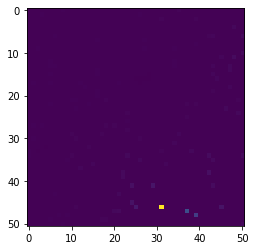

In [78]:
# Prepare data
W = torch.from_numpy(O_mat).type(torch.float32)
X = torch.from_numpy(T).type(torch.float32)
z = torch.from_numpy(S_tensor).type(torch.float32)
C = torch.from_numpy(C).type(torch.float32)
R = C.shape[1]

K = X.shape[2]

X = X.permute(2,0,1)
z = z.permute(2,0,1)
z = z.unsqueeze(dim=1)
C = C.permute(1,0)
W = W.unsqueeze(dim=0)
W = W.unsqueeze(dim=0)
Wr = W.repeat(R,1,1,1)
Wx = W.repeat(K,1,1,1)

Wr[Wr<0.5] = 0
Wr[Wr>=0.5] = 1

test_slf = torch.cat((Wr, z), dim=1)
test_slf.requires_grad = True

for i in range(100):
    slf_complete = slf_network(test_slf)

#         plt.imshow(slf_complet)
    # slf_complete = slf_complete.view(R,51,51)
    # reconstruct the map from slf 
    # first normalize slf
    # slf_complete_norm = torch.zeros((slf_complete.shape))
    # for rr in range(R):
    #     slf_complete[rr] = slf_complete[rr]/(slf_complete[rr].norm())
    X_from_slf = get_tensor(slf_complete[:,0,:,:], C)


    loss = criterion(Wx*X, Wx*X_from_slf)
#     print(loss)
    plt.imshow(test_slf[0,1,:,:].detach())
    loss.backward()
    with torch.no_grad():
        test_slf -= 0.03*test_slf.grad
    true_loss = criterion(X, X_from_slf)
    print('sampled_loss: {} true_loss: {}'.format(loss.item(), true_loss.item()))
slf_opt = test_slf[:,1,:,:]
#     return slf_opt.permute(1,2,0)

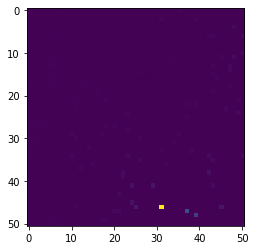

In [69]:
plt.imshow(test_slf[0,1,:,:].detach())

In [48]:
slf_complete = slf_network(test_slf)

In [28]:
W.shape

torch.Size([1, 1, 51, 51])

In [37]:
test_slf[test_slf<0.0001] = 0

In [79]:
a = torch.ones(2,2,3
              )

In [81]:
b = torch.zeros(2,2,3)

In [82]:
criterion(a,b)

tensor(1.)

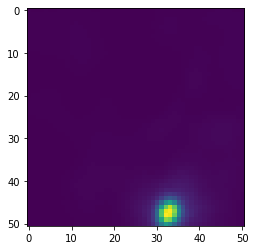

In [68]:
plt.imshow(slf_complete[0,0,:,:].detach())

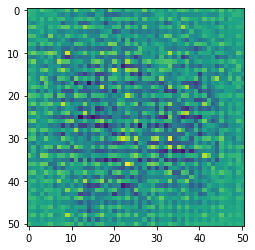

In [17]:
plt.imshow(ans[0,0,:,:].detach())